In [1]:
import jax
import jax.numpy as jnp
jax.config.update("jax_enable_x64", True)
import matplotlib.pyplot as plt
%matplotlib inline
import s2fft
from healpy import mollview
from croissant import crojax

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


True
(41, 129, 257)


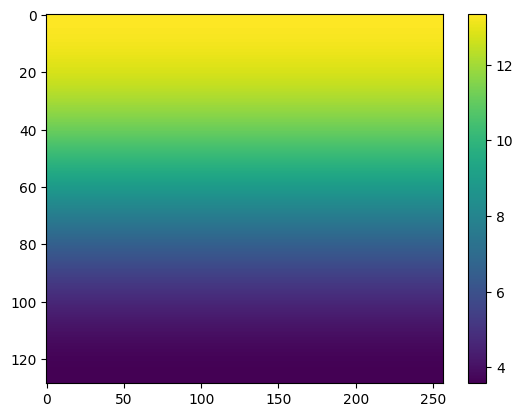

In [2]:
# simple beam in topocentric coordinates
lmax = 128
freq = jnp.linspace(40, 80, 41)
beam = crojax.Beam.zeros(lmax, frequencies=freq, coord="T")

# set (l=0, m=0) and (l=1, m=0) mode
beam[:, 0, 0] = 30 * (freq/freq[0]) ** 2
beam[:, 1, 0] = 10 * (freq/freq[0])**2
print(beam.is_real)

# visualize
nside = None
sampling = "mw"  # mw, mwss, dh, healpix
if sampling == "healpix":
    nside = 2 * lmax
m = beam.alm2map(sampling=sampling, nside=nside, frequencies=freq)
print(m.shape)
if sampling == "healpix":
    mollview(m[0])
else:
    plt.figure()
    plt.imshow(m[0], aspect="auto")
    plt.colorbar()
    plt.show()

In [3]:
# precompute ...

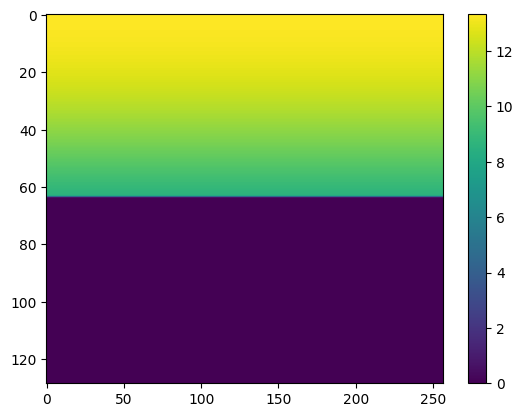

In [4]:
# we can impose a horizon like this, ripples are due to finite lmax (a sharp edge requires infinite ell)
beam.horizon_cut()
m = beam.alm2map(sampling=sampling, nside=nside, frequencies=freq[0])
plt.figure()
plt.imshow(m[0], aspect="auto")
plt.colorbar()
plt.show()
#mollview(m[0], title=f"Beam at {freq[0]:.0f} MHz")

We use the Global Sky Model (Zheng et al 2016) at 25 MHz as the sky model. It has a built-in interface in the sky module of croissant.

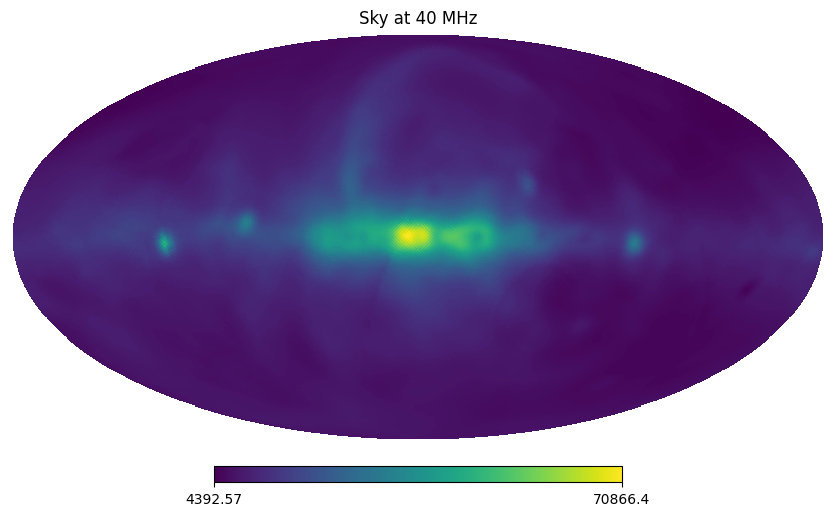

In [5]:
sky = crojax.Sky.gsm(beam.frequencies, lmax=beam.lmax.item())
m = sky.alm2map(sampling="healpix", nside=64, frequencies=freq[0])
mollview(m[0], title=f"Sky at {freq[0]:.0f} MHz")

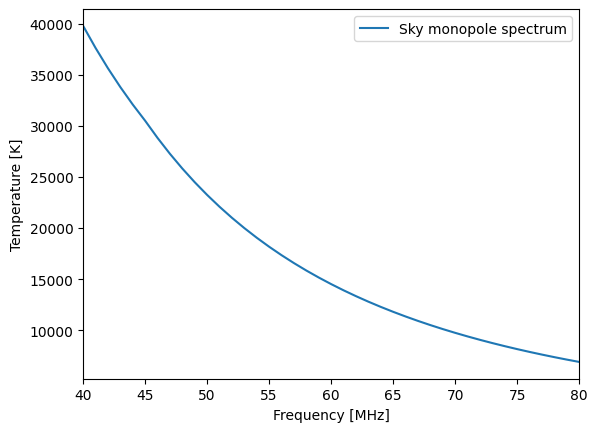

In [7]:
plt.figure()
plt.plot(sky.frequencies, jnp.real(sky[:, 0, 0]), label="Sky monopole spectrum")
plt.xlabel("Frequency [MHz]")
plt.ylabel("Temperature [K]")
plt.xlim(sky.frequencies.min(), sky.frequencies.max())
plt.legend()
plt.show()

In [ ]:
# let's do a full sidereal day on the moon
loc = (20., -10.)
t_start = Time("2022-06-02 15:43:43")
t_end = t_start + cro.constants.sidereal_day_moon * seconds
sim = cro.Simulator(beam, sky, loc, t_start, world="moon", t_end=t_end, N_times=300, lmax=lmax)

In [ ]:
# the simulator view of the beam and sky after moving to MCMF coordinates
hp.mollview(sim.beam.hp_map(nside)[0], title=f"Beam at {freq[0]:.0f} MHz")
hp.mollview(sim.sky.hp_map(nside)[0], title=f"Sky at {freq[0]:.0f} MHz")

Run the simulator!

In [ ]:
# dpss mode
sim.run(dpss=True, nterms=40)
sim.plot(power=2.5)

In [ ]:
sim.run(dpss=False)
sim.plot(power=2.5)

In [ ]:
plt.figure()
plt.plot(sim.frequencies, sim.waterfall[::10].T, ls="--")
plt.xlim(sim.frequencies.min(), sim.frequencies.max())
plt.xlabel("$\\nu$ [MHz]")
plt.ylabel("Temperature [K]")
plt.grid()
plt.show()

In [ ]:
# Temp vs time
fig, axs = plt.subplots(figsize=(13,5), ncols=5, sharex=True, sharey=True)
for i, f in enumerate(sim.frequencies[::10]):
    ax = axs.ravel()[i]
    fidx = np.argwhere(sim.frequencies == f)[0, 0]
    ax.plot(sim.waterfall[:, fidx] * f**2.5)
    ax.set_title(f"{f} MHz")
    ax.grid()
plt.tight_layout()
plt.show()

# On Earth

In [ ]:
loc = (20., -10.)
t_start = Time("2022-06-02 15:43:43")
t_end = t_start + cro.constants.sidereal_day_earth * seconds
sim = cro.Simulator(beam, sky, loc, t_start, world="earth", t_end=t_end, N_times=300, lmax=lmax)

In [ ]:
# the simulator view of the beam and sky after moving to equatorial coordinates
hp.mollview(sim.beam.hp_map(nside)[0], title=f"Beam at {freq[0]:.0f} MHz")
hp.mollview(sim.sky.hp_map(nside)[0], title=f"Sky at {freq[0]:.0f} MHz")

In [ ]:
# dpss mode
sim.run(dpss=True, nterms=40)
sim.plot(power=2.5)

In [ ]:
# Temp vs time
fig, axs = plt.subplots(figsize=(13,5), ncols=5, sharex=True, sharey=True)
for i, f in enumerate(sim.frequencies[::10]):
    ax = axs.ravel()[i]
    fidx = np.argwhere(sim.frequencies == f)[0, 0]
    ax.plot(sim.waterfall[:, fidx] * f**2.5)
    ax.set_title(f"{f} MHz")
    ax.grid()
plt.tight_layout()
plt.show()